In [10]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
import re
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

load_dotenv()

memory = MemorySaver()

class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x - 10) + ((2x - 10) - 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 * #E2 - 10) - 8]

Begin! 
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}"""


# Regex to match expressions of the form E#... = ...[...]
regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | llm


# To connect the planner to our graph
def get_plan(state: ReWOO):
    task = state["task"]
    result = planner.invoke({"task": task})
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}


# Executor
search = TavilySearchResults(max_results=1)

def _get_current_task(state: ReWOO):
    if "results" not in state or state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1


def tool_execution(state: ReWOO):
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    _results = (state["results"] or {}) if "results" in state else {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool == "Google":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        result = llm.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}


# Solver
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""


def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = (state["results"] or {}) if "results" in state else {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = llm.invoke(prompt)
    return {"result": result.content}

In [11]:
# Define graph

def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

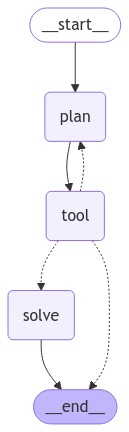

In [12]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [15]:
task = "Write me a movie script about Nigeria and its economic situation"

for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'plan_string': "Here's a step-by-step plan to write a movie script about Nigeria and its economic situation:\n\nPlan: Research the current economic situation in Nigeria.\n\n#E = Google[Current economic situation in Nigeria]\n\nThis plan uses the Google tool to search for information on the current economic situation in Nigeria. The search query will retrieve relevant news articles, reports, and statistics that can be used as a foundation for the movie script.\n\nPlan: Identify key economic challenges facing Nigeria.\n\n#E1 = LLM[What are some of the major economic challenges facing Nigeria, given #E]\n\nThis plan uses the LLM (Large Language Model) tool to analyze the information retrieved in the previous step and identify the key economic challenges facing Nigeria. The LLM can provide a summary of the information and highlight the most significant issues, such as corruption, poverty, and infrastructure challenges.\n\nPlan: Develop a storyline around the economic challenges f